# Final machine learning project 2022 - BMEN 619
### Maya Stibbards-Lyle

#### Question: Can k-means clustering be used to show an association between two relevant conditions (fluid shear stress and postpartum status)?

Gene expression levels can be obtained from performing RNA-sequencing on samples. Gene expression is a proximate for the activity level of a given gene. Therefore gene expression can provide information regarding specific processes activated by certain conditions (such as shear stress or childbearing).

#### General Description: Examining two publicly available RNA-seq datasets using k-means clustering. Example code from https://github.com/ageron/handson-ml2/blob/master/09_unsupervised_learning.ipynb
##### Table of contents:
1. Data import and preparation
   
    1.1 First dataset (Fluid shear stress)
    
    1.2 Second dataset (Postpartum breast cancer dataset)
    
    1.3 Combining datasets into one dataframe
    
    1.4 Scaling the data


2. Kmeans clustering
    
    2.1 First try
    
    2.2 Determining the best number of clusters
        

3. Density mapping and anomaly detection
    
    3.1 Gaussian Mixture
    
    3.2 Looking at different covariance types
    
    3.3 Bayesian information criterion (BIC) and Akaike information criterion (AIC) to determine best cluster number and best covariance type
    
    3.4 Anomaly detection

In [1]:
# Common imports
import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import os
import csv

# Using pandas to format datasets
import pandas as pd

# To make this notebook's output stable across runs
np.random.seed(42)

# Pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import math # For log and mean operations

## 1. Data import and preparation

### 1.1 First dataset (Fluid shear stress)

In [2]:
# Opening the fluid shear stress (FSS) dataset
path1 = 'GSE191142_Norm_counts.csv' # Dataset is an Excel.csv file

In [3]:
df_FSS = pd.read_csv(path1) # Creating dataframe from .csv file
df_FSS.rename({'SYMBOL': 'gene_symbol'}, axis='columns', inplace=True) # Renaming the gene name column for clarity
df_FSS = df_FSS.set_index('gene_symbol') # Setting gene_symbol as the index
df_FSS.head()

ENTREZID    MCF7S1    MCF7S2    MCF7S3    MCF7W1    MCF7W2  \
gene_symbol                                                               
A1BG                1  0.767236  0.755971  1.325451  0.648523  0.360189   
A2M                 2 -1.272293 -2.788349 -0.572670 -0.870851 -1.068654   
A2MP1               3 -4.442218 -4.373312 -4.032101 -3.192780 -4.769094   
NAT1                9  2.452600  1.930469  1.695819  3.074007  3.131773   
NAT2               10 -2.120290 -4.373312 -2.447139 -1.970387 -4.769094   

               MCF7W3  HCC1187S1  HCC1187S2  HCC1187S3  ...   EFM19S3  \
gene_symbol                                             ...             
A1BG         0.157246  -1.968095  -2.313028  -1.320567  ...  1.319169   
A2M         -0.709488  -4.775450  -3.049993  -2.905529  ... -4.462190   
A2MP1       -3.211988  -4.775450  -4.634956  -4.490492  ... -4.462190   
NAT1         3.029598   3.409426   2.880744   2.329687  ...  1.766628   
NAT2        -1.989596  -3.190487  -2.313028  -2.905529  ... -4.462190   

              EFM19W1   EFM19W2   EFM19W3  MDAMB231S1  MDAMB231S2  MDAMB231S3  \
gene_symbol                                                                     
A1BG        -0.693856 -0.047759 -1.350565    0.242244   -0.236181   -0.311726   
A2M         -4.394296 -4.571321 -4.157920   -4.887039   -4.759743   -2.974691   
A2MP1       -4.394296 -4.571321 -4.157920   -4.887039   -4.759743   -4.559653   
NAT1         2.900325  3.021137  2.853307    2.370349    2.588985    1.979506   
NAT2        -4.394296 -4.571321 -4.157920   -3.302076   -4.759743   -1.389728   

             MDAMB231W1  MDAMB231W2  MDAMB231W3  
gene_symbol                                      
A1BG          -1.726299   -2.659653   -1.001697  
A2M           -4.048227   -4.244616   -2.224089  
A2MP1         -4.048227   -4.244616   -3.809052  
NAT1           2.963000    3.271084    3.467073  
NAT2          -2.463265   -2.659653   -3.809052  

[5 rows x 25 columns]

##### Here we can see a dataframe of the first dataset. There is a lot of information and samples here, so I will clean it up in the following steps.

In [4]:
df_FSS.drop('ENTREZID', inplace=True, axis=1) # Dropping irrelevant column
df_FSS.drop(list(df_FSS.filter(regex='MCF')), axis = 1, inplace = True) # Dropping irrelevant columns
df_FSS['W_MEAN'] = df_FSS.filter(regex='W\d+').mean(axis=1) # Taking the mean of all columns that have 'W' (shear stress cond.)
df_FSS['S_MEAN'] = df_FSS.filter(regex='S\d+').mean(axis=1) # Taking the mean of all columns that have 'S' (static cond.)
df_FSS['DEG_FSS'] = df_FSS['W_MEAN'] - df_FSS['S_MEAN'] # Taking the difference (also known as differential gene exp.)
df_FSS = df_FSS.loc[(df_FSS!=0).all(axis=1)] # Dropping any rows where either of the gene expression values are equal to zeroes
df_FSS[['W_MEAN', 'S_MEAN', 'DEG_FSS']].head() # Show dataframe

W_MEAN    S_MEAN   DEG_FSS
gene_symbol                              
A1BG        -1.817624 -0.129569 -1.688054
A2M         -3.613250 -4.089901  0.476651
A2MP1       -4.141571 -4.618222  0.476651
NAT1         3.282176  2.341953  0.940224
NAT2        -3.613250 -3.479695 -0.133555

##### The column 'gene_symbol' represents the name of every measurable gene in the samples. W_Mean is a representation of each gene's expression level in samples where cells were exposed to shear stress. S_Mean represents each gene's expression level in samples NOT exposed to shear stress. The DEG_FSS column is therefore a representation of the change in cells' gene expression upon exposure to shear stress.

### 1.2 Preparation of second dataset (Postpartum breast cancer dataset)

In [5]:
# Opening involution dataset
path2 = 'GSE158854_Avon_Breast_Cancer_RSEM_FPKM.txt.gz'

In [6]:
df_PPBC = pd.read_csv(path2, compression='gzip', header=0, sep='\t', quotechar='"') # Directly importing second dataset which is a compressed file
df_PPBC = df_PPBC.set_index('gene_symbol')
df_PPBC = df_PPBC.loc[(df_PPBC!=0).all(axis=1)] # Drop all rows containing any zeroes
df_PPBC.head()

S10_PPBC_FPKM  S5_Nullip_FPKM  S3_Nullip_FPKM  S9_Nullip_FPKM  \
gene_symbol                                                                  
RAB4B                 2.70            2.09            1.76            3.59   
C12orf5               3.99            5.44            3.36            4.80   
PIGV                  7.36            7.83            4.41           10.20   
ZRANB1               12.28           12.85           10.33            8.55   
MFSD3                 5.01            2.32            4.98            4.92   

             S13_PPBC_FPKM  S14_Nullip_FPKM  S8_PPBC_FPKM  S7_PPBC_FPKM  \
gene_symbol                                                               
RAB4B                 3.21             4.63          4.16          3.43   
C12orf5               5.81             6.89          3.48          5.03   
PIGV                  5.97             6.49         14.80         10.98   
ZRANB1               11.66            16.54         12.46          9.12   
MFSD3                 3.56             5.80          7.23          8.54   

             S15_PPBC_FPKM  S4_PPBC_FPKM  S1_Nullip_FPKM  S6_Nullip_FPKM  \
gene_symbol                                                                
RAB4B                 1.48          2.79            2.03            2.15   
C12orf5               3.02          3.63            4.91            2.40   
PIGV                  6.37          5.88            9.92           13.79   
ZRANB1               15.32         28.42           10.67           14.08   
MFSD3                 6.95          3.05            5.58            1.98   

             S12_PPBC_FPKM  S11_Nullip_FPKM  S16_PPBC_FPKM  S2_PPBC_FPKM  
gene_symbol                                                               
RAB4B                 2.24             3.58           2.55          4.01  
C12orf5               6.16             6.83           3.00         10.97  
PIGV                  9.09            15.75          10.23          5.08  
ZRANB1               11.84            17.41          15.81         11.06  
MFSD3                 3.74             7.47          22.00          2.72

##### Here we see a similar type of dataframe. Each column represents a sample. 'PPBC' represents samples from women with postpartum breast cancer. 'Nullip' represents samples from women with cancer that have never given birth. In order to deternine the effect of postpartum status on gene expression, we need to take the difference between the two samples across all genes.

In [7]:
df_PPBC['PPBC'] = (np.log2(df_PPBC.filter(like='PPBC', axis=1))).mean(axis=1) # Taking the log and mean of all cancerous samples
df_PPBC['Nullip'] = (np.log2(df_PPBC.filter(like='Nullip', axis=1))).mean(axis=1) # Taking the log and mean of all non-cancerous samples
df_PPBC['DEG_PPBC'] = df_PPBC['PPBC'] - df_PPBC['Nullip'] # Taking the difference between the cancerous and non-cancerous means to create the differential gene expression for each gene in the dataset
#df_PPBC = df_PPBC.drop(df_PPBC[(df_PPBC['DEG_PPBC'] < 0.2) & (df_PPBC['DEG_PPBC'] > -0.2)].index)
df_PPBC[['PPBC', 'Nullip', 'DEG_PPBC']].head()

PPBC    Nullip  DEG_PPBC
gene_symbol                              
RAB4B        1.501532  1.414264  0.087267
C12orf5      2.198053  2.224321 -0.026269
PIGV         2.990302  3.175954 -0.185652
ZRANB1       3.752425  3.649884  0.102541
MFSD3        2.479646  2.104551  0.375096

##### So now we have two cleaned-up dataframes and our two differential gene expression levels. Therefore we have a proximate for the effect of each condition of interest (shear stress and recent childbearing) on every gene. Now we can plot each instance (gene) and see if there is any relationship between the effects of shear stress vs. recent childbearing on the expression level of genes.

### 1.3 Combining datasets into one dataframe

In [8]:
# Combining all the dataframes into a final version
df_X = pd.merge(df_PPBC['DEG_PPBC'], df_FSS['DEG_FSS'], on='gene_symbol') # Merging dataframes
df_X = df_X.drop(df_X[(df_X['DEG_FSS'] > 1000) & (df_X['DEG_FSS'] < -1000)].index) # Dropping large outliers which are likely technical errors
df_X = df_X.drop(df_X[(df_X['DEG_PPBC'] > 1000) & (df_X['DEG_PPBC'] < -1000)].index) # ...
df_X = df_X.dropna(axis=0) # Drop all NaN values
df_X = df_X.drop(df_X[(df_X['DEG_PPBC'] == 0) | (df_X['DEG_FSS'] == 0)].index) # Dropping any rows with zeroes in either column
df_X.head()

DEG_PPBC   DEG_FSS
gene_symbol                    
RAB4B        0.087267  0.476651
PIGV        -0.185652 -0.608331
ZRANB1       0.102541  0.083818
MFSD3        0.375096 -0.519885
CALB2       -0.686243  0.502040

### 1.4 Scaling the data

In [9]:
# Dropping the most commmon values because they appeared a disproportionate amount of times in the FSS dataset (likely technical error)
errors = list(df_X['DEG_FSS'].value_counts().index[:7])
df_X = df_X[~df_X['DEG_FSS'].isin(errors)]

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() 

df_scaled_X = df_X.copy()
df_scaled_X[['DEG_FSS','DEG_PPBC']] = scaler.fit_transform(df_X) # Scaling the data

df_scaled_X.head

<bound method NDFrame.head of              DEG_PPBC   DEG_FSS
gene_symbol                    
PIGV         0.491768  0.408136
ZRANB1       0.591302  0.446648
MFSD3        0.504487  0.483070
CALB2        0.651445  0.341240
ZNF708       0.768684  0.349609
...               ...       ...
KIF16B       0.461608  0.403301
STAU1        0.566427  0.456023
LIN7C        0.652764  0.413866
PPP6R1       0.623081  0.465764
BATF3        0.642087  0.436321

[14276 rows x 2 columns]>

C:\Users\Maya\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Maya\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Scaled data')

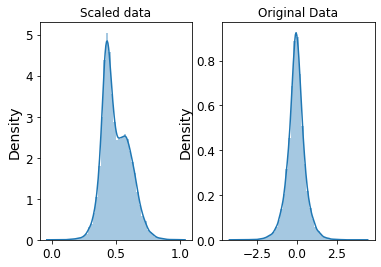

In [11]:
import seaborn as sns

fig, ax=plt.subplots(1,2)
sns.distplot(df_X, ax=ax[1])
ax[1].set_title("Original Data") # Plotting the orignal data
sns.distplot(df_scaled_X, ax=ax[0])
ax[0].set_title("Scaled data") # Plotting the new, scaled data

## 2. Kmeans clustering

### Plotting

In [12]:
# Defining functions for figure plotting - github.com/ageron/handson-ml2/blob/master/09_unsupervised_learning.ipynb
def plot_data(X):
    plt.plot(X.iloc[:, 0], X.iloc[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    plt.tick_params(labelsize=30)
    
    if show_xlabels:
        plt.xlabel("$FSS\ relative\ gene\ expression$", fontsize=30)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$PPBC\ relative\ gene\ expression$", fontsize=30, rotation=90)
    else:
        plt.tick_params(labelleft=False)

### 2.1 First try

In [13]:
from sklearn.cluster import KMeans
k = 3 # Guessing a random number of clusters just to see what happens
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(df_scaled_X)

y_pred # Each one of the instances was assigned to one of the clusters

array([1, 0, 0, ..., 2, 0, 2])

In [14]:
kmeans.cluster_centers_ # Finding the centers of the clusters

array([[0.56601575, 0.45430114],
       [0.4549926 , 0.4076719 ],
       [0.67093989, 0.41206083]])

C:\Users\Maya\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


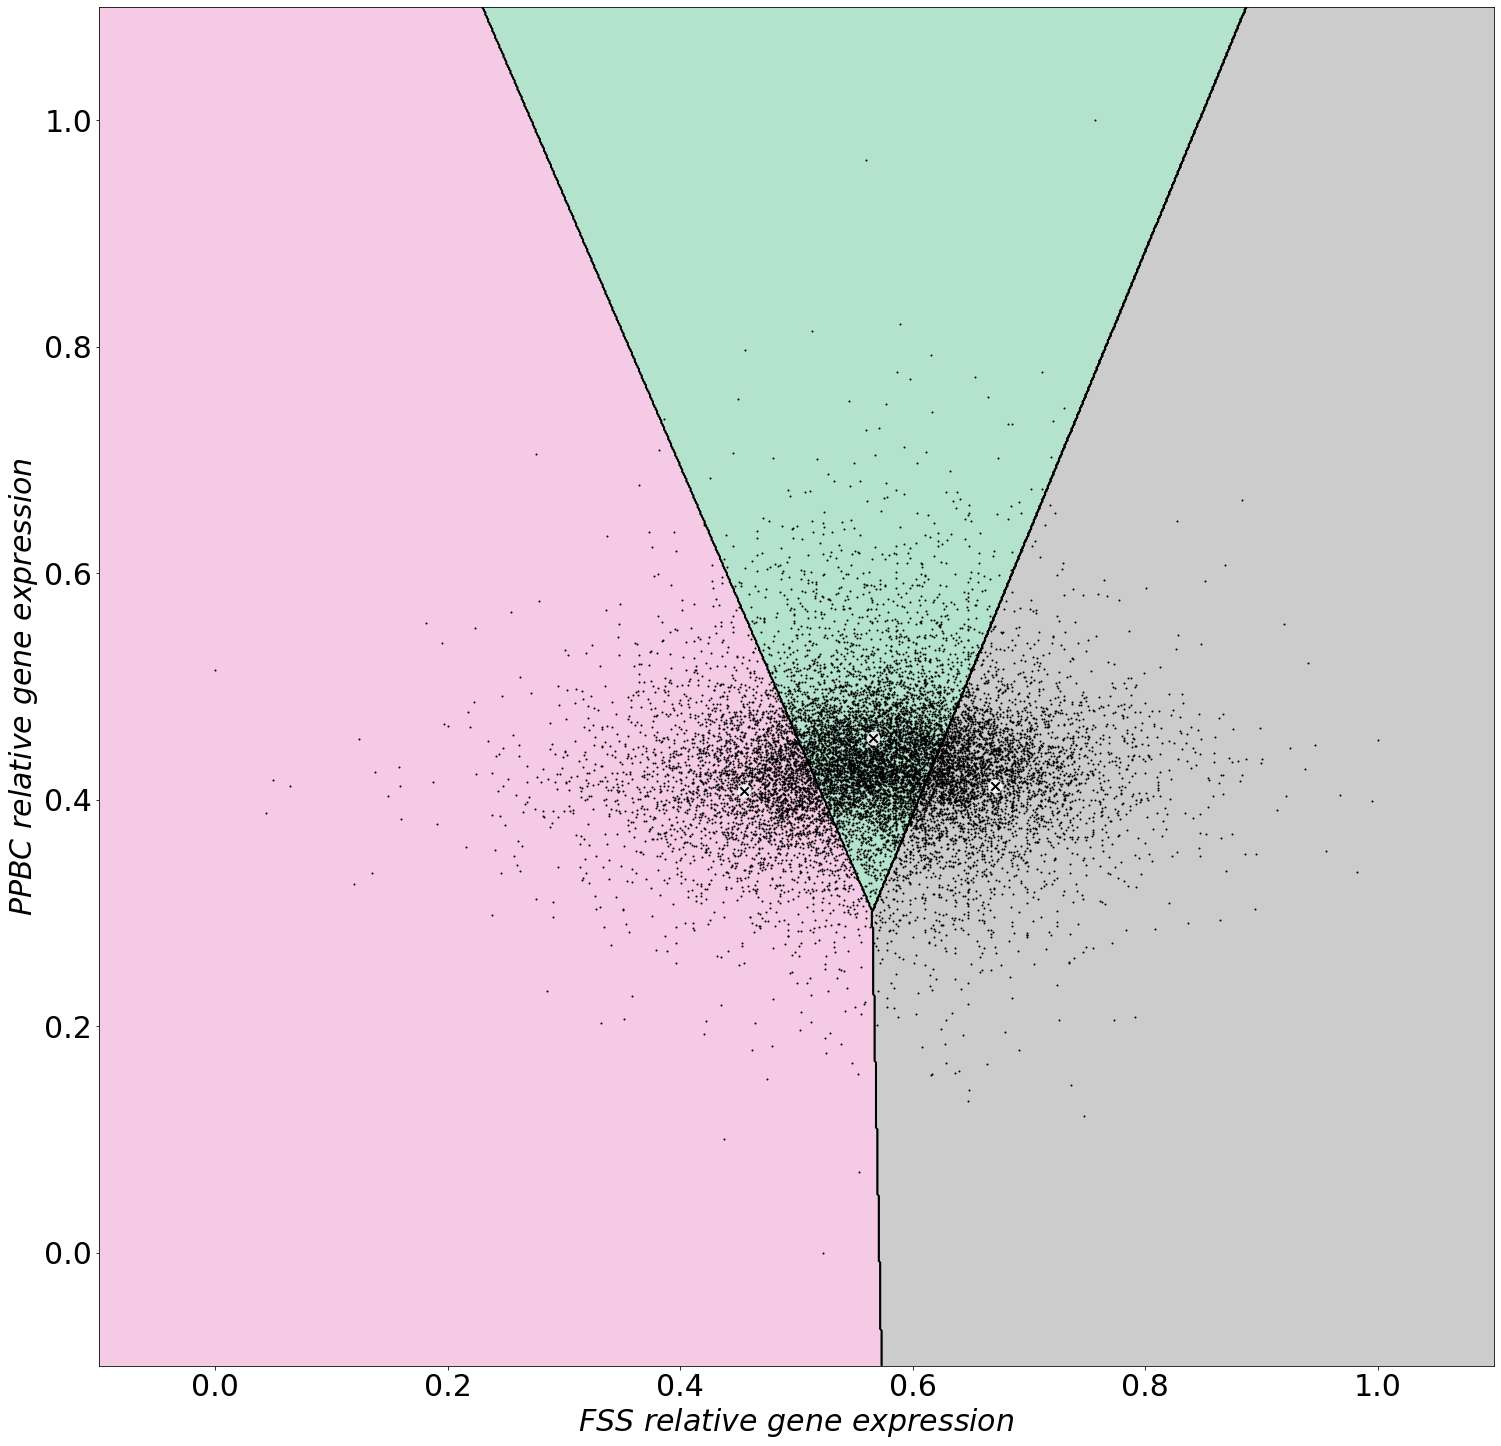

In [15]:
plt.figure(figsize=(25, 25))
plot_decision_boundaries(kmeans, df_scaled_X) # Showing decision boundaries for the clustering 
plt.show()

##### So obviously this does cluster (and fairly effectively) but we have no idea if this is the most effective number of clusters.

### 2.2 Determining the best number of clusters

In [16]:
# Defining function to compare different k's visually
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(20, 15))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

C:\Users\Maya\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
C:\Users\Maya\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


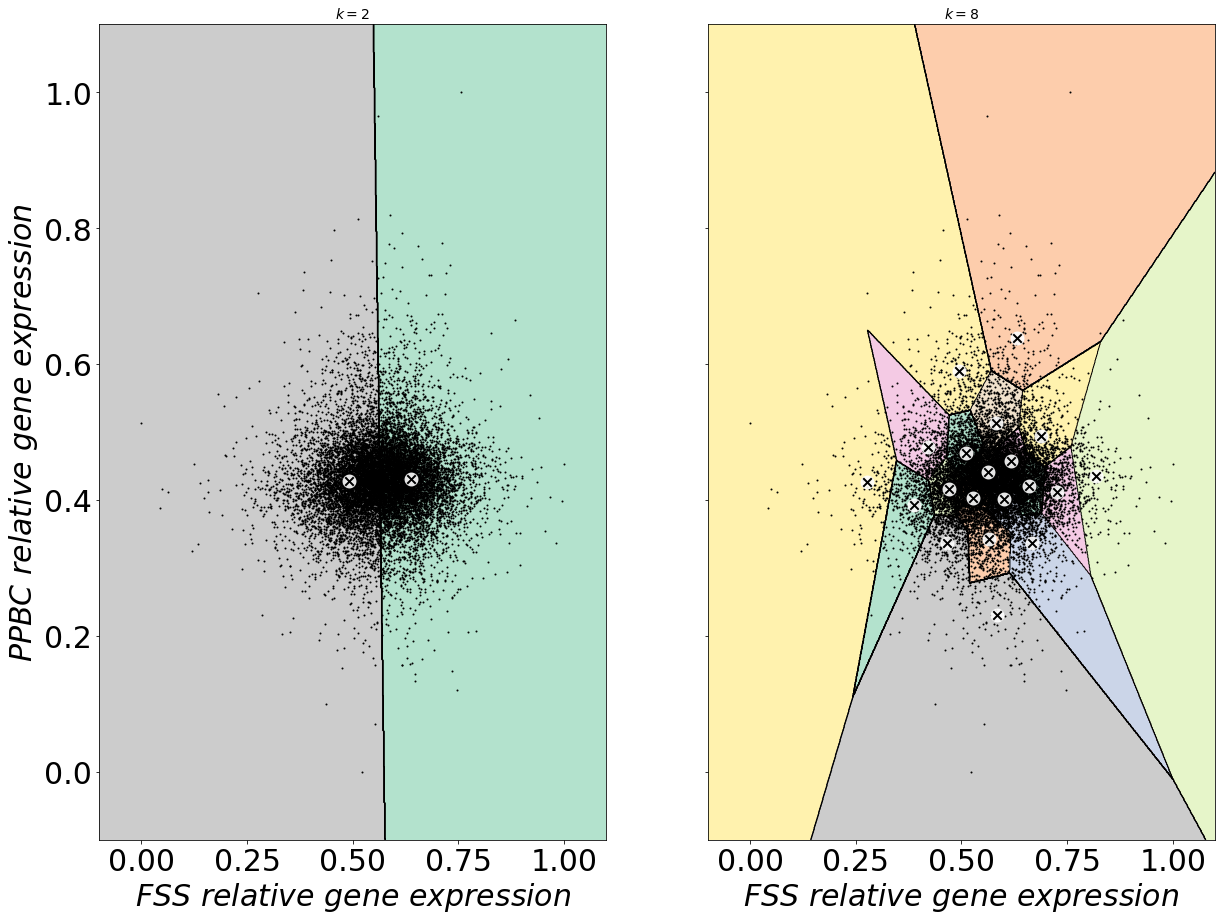

In [17]:
# Comparing a couple more numbers of clusters just to show how different they can look
kmeans_k2 = KMeans(n_clusters=2, random_state=42) # Clustering with 2 clusters
kmeans_k8 = KMeans(n_clusters=20, random_state=42) # Clustering with 8 clusters

plot_clusterer_comparison(kmeans_k2, kmeans_k8, df_scaled_X, "$k=2$", "$k=8$") # Showing both side by side
plt.show()

##### Next, I'm going to look at inertia, which is a measure of clustering effectiveness

In [18]:
kmeans_k2.inertia_ 

105.76603108581321

##### Inertia represents the mean squared distance between each instance and its closest centroid. It will naturally continue decreasing as more clusters are added (since each instance will gradually get closer to a centroid), but we want to minimize the inertia AND minimize the cluster number.

In [19]:
kmeans_k8.inertia_

17.448931993569147

In [20]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(df_scaled_X) for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k] # Looking at how the intertia decreases as the amount of clusters increases

##### While inertia is inevitably going to decrease with more clusters, some k's are going to be associated with a bigger, disproportionate decrease in inertia. So let's take a look at the decrease in inertia with increasing k.

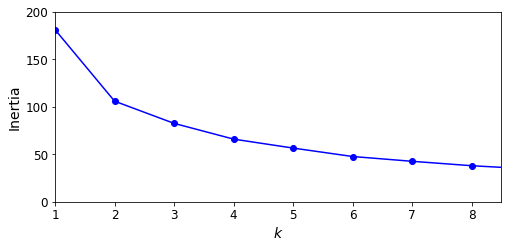

In [21]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.axis([1, 8.5, 0, 200])
plt.show()

##### Next I moved on to calculating the silhouette score across different clusters
The silhouette score for a given instance is: (b – a) / max(a, b) where a is the mean distance to the other instances in the same cluster and b is the mean nearest-cluster distance.
##### Therefore, the silhouette score is a representation of how well an instance has been clustered (is it closer to its cluster neighbours or instances in other clusters?).

##### A silhouette score of 0 means that a given instance is close to the cluster boundary, and score close to +1 means that a given instance is well within its cluster borders 

In [22]:
from sklearn.metrics import silhouette_score
silhouette_score(df_scaled_X, kmeans.labels_)

0.31027688435978246

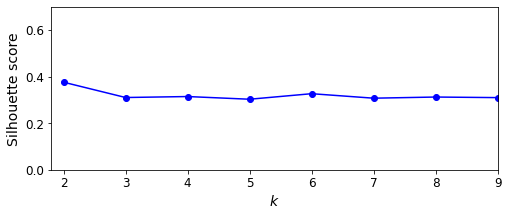

In [23]:
silhouette_scores = [silhouette_score(df_scaled_X, model.labels_)
                     for model in kmeans_per_k[1:]] # Calculating the silhouette score of each instance
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-") # Calculating silhouette scores for k=2 to k=9
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 9, 0, 0.7])
plt.show()

##### We don't really see any new information here (no peaks, which would represent an ideal cluster number)

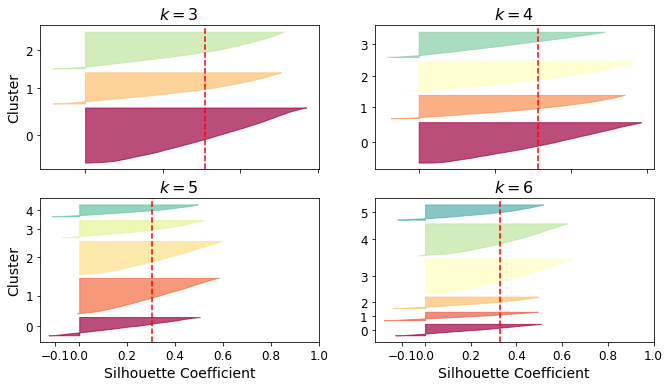

In [24]:
# Complicated plotting stuff that I got from the ageron demo
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(3, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(df_scaled_X, y_pred)

    padding = len(df_scaled_X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

##### Here we can see silhouette diagrams across 4 different k's. The mean silhouette coefficient is represented by the dashed red line. The height of the knife shapes represents the number of instances in each cluster (which we want to be as evenly distributed as possible). The highest mean silhouette coefficent seems to be when there are 4 clusters. These clusters seem to be pretty well-distributed so we will proceed with k=4.

In [25]:
k = 4 # number of clusters dictated
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(df_scaled_X)

y_pred
y_pred is kmeans.labels_

True

C:\Users\Maya\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


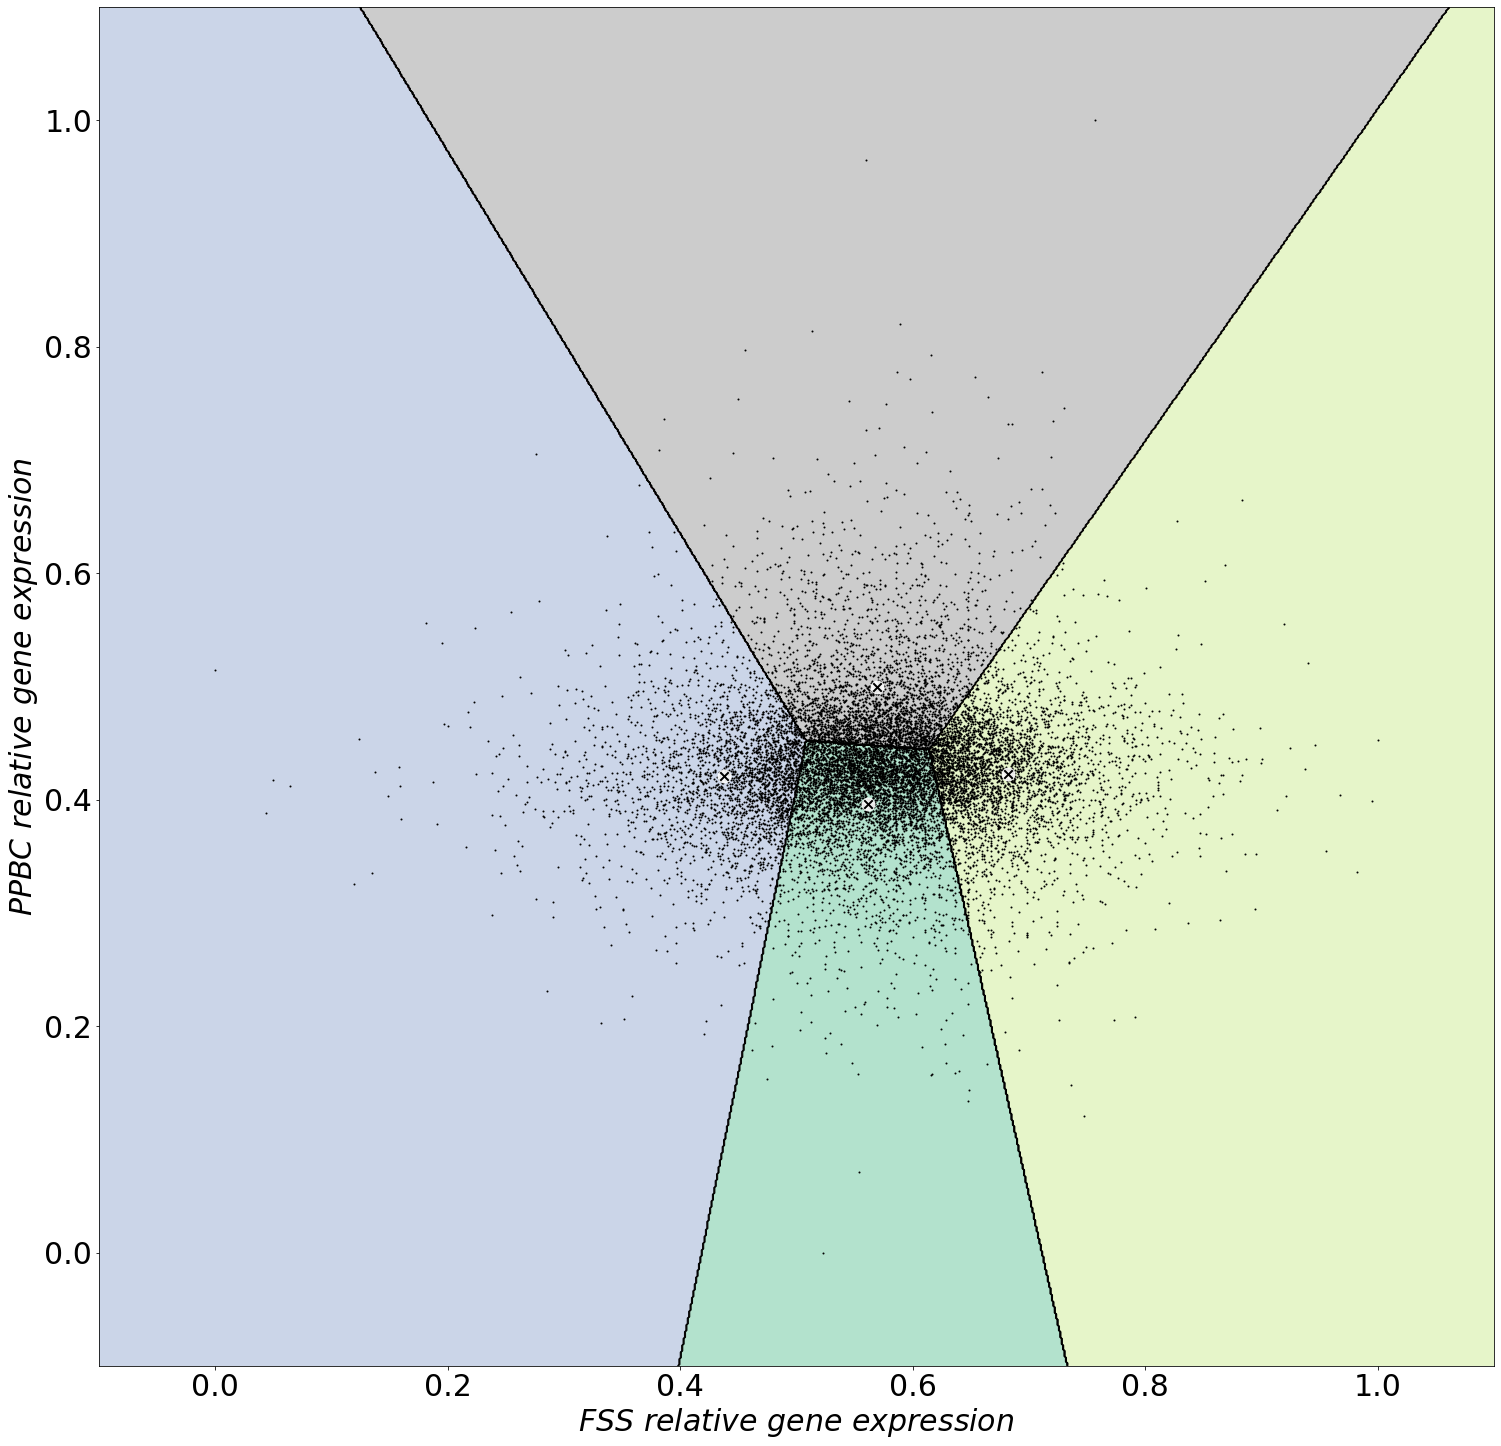

In [26]:
plt.figure(figsize=(25, 25))
plot_decision_boundaries(kmeans, df_scaled_X)
plt.show()

##### This is not a very exciting clustering, since the data seems to have a pretty normal distribution. Since there are no obvious associations, I will move on to density mapping and anomaly detection using GM.

## 3. Density mapping and anomaly detection

### 3.1 Gaussian Mixture

In [27]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=4, n_init=10, random_state=42)
gm.fit(df_scaled_X)

GaussianMixture(n_components=4, n_init=10, random_state=42)

##### GM uses Expectation-Maximization which is a fairly similar algorithm to Kmeans (expectation = assigning i to cluster, maximization = optimizing)

In [28]:
gm.weights_ # Weights of each cluster

array([0.22949406, 0.40283665, 0.18129671, 0.18637258])

In [29]:
gm.means_ # Means of each cluster

array([[0.6487992 , 0.42651125],
       [0.56400164, 0.43042871],
       [0.47426684, 0.41603785],
       [0.57456942, 0.4460832 ]])

In [30]:
gm.covariances_ # Variance of each cluster

array([[[ 0.00651183, -0.00017436],
        [-0.00017436,  0.00216171]],

       [[ 0.00353331,  0.00011659],
        [ 0.00011659,  0.00109007]],

       [[ 0.00884241, -0.00011927],
        [-0.00011927,  0.00303917]],

       [[ 0.00661291, -0.00034326],
        [-0.00034326,  0.0120343 ]]])

In [31]:
gm.converged_ # Did the algorithm converge?

True

In [32]:
gm.n_iter_ # How many iterations did it take?

12

In [33]:
from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True): # Defining function for plotting of density map
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X.iloc[:, 0], X.iloc[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)
    
    plt.tick_params(labelsize=30)

    plt.xlabel("$PPBC$", fontsize=30)
    if show_ylabels:
        plt.ylabel("$FSS$", fontsize=30, rotation=0)
    else:
        plt.tick_params(labelleft=False)

C:\Users\Maya\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
C:\Users\Maya\AppData\Local\Temp\ipykernel_17532\4202035290.py:11: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contourf(xx, yy, Z,
C:\Users\Maya\AppData\Local\Temp\ipykernel_17532\4202035290.py:14: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contour(xx, yy, Z,
C:\Users\Maya\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(


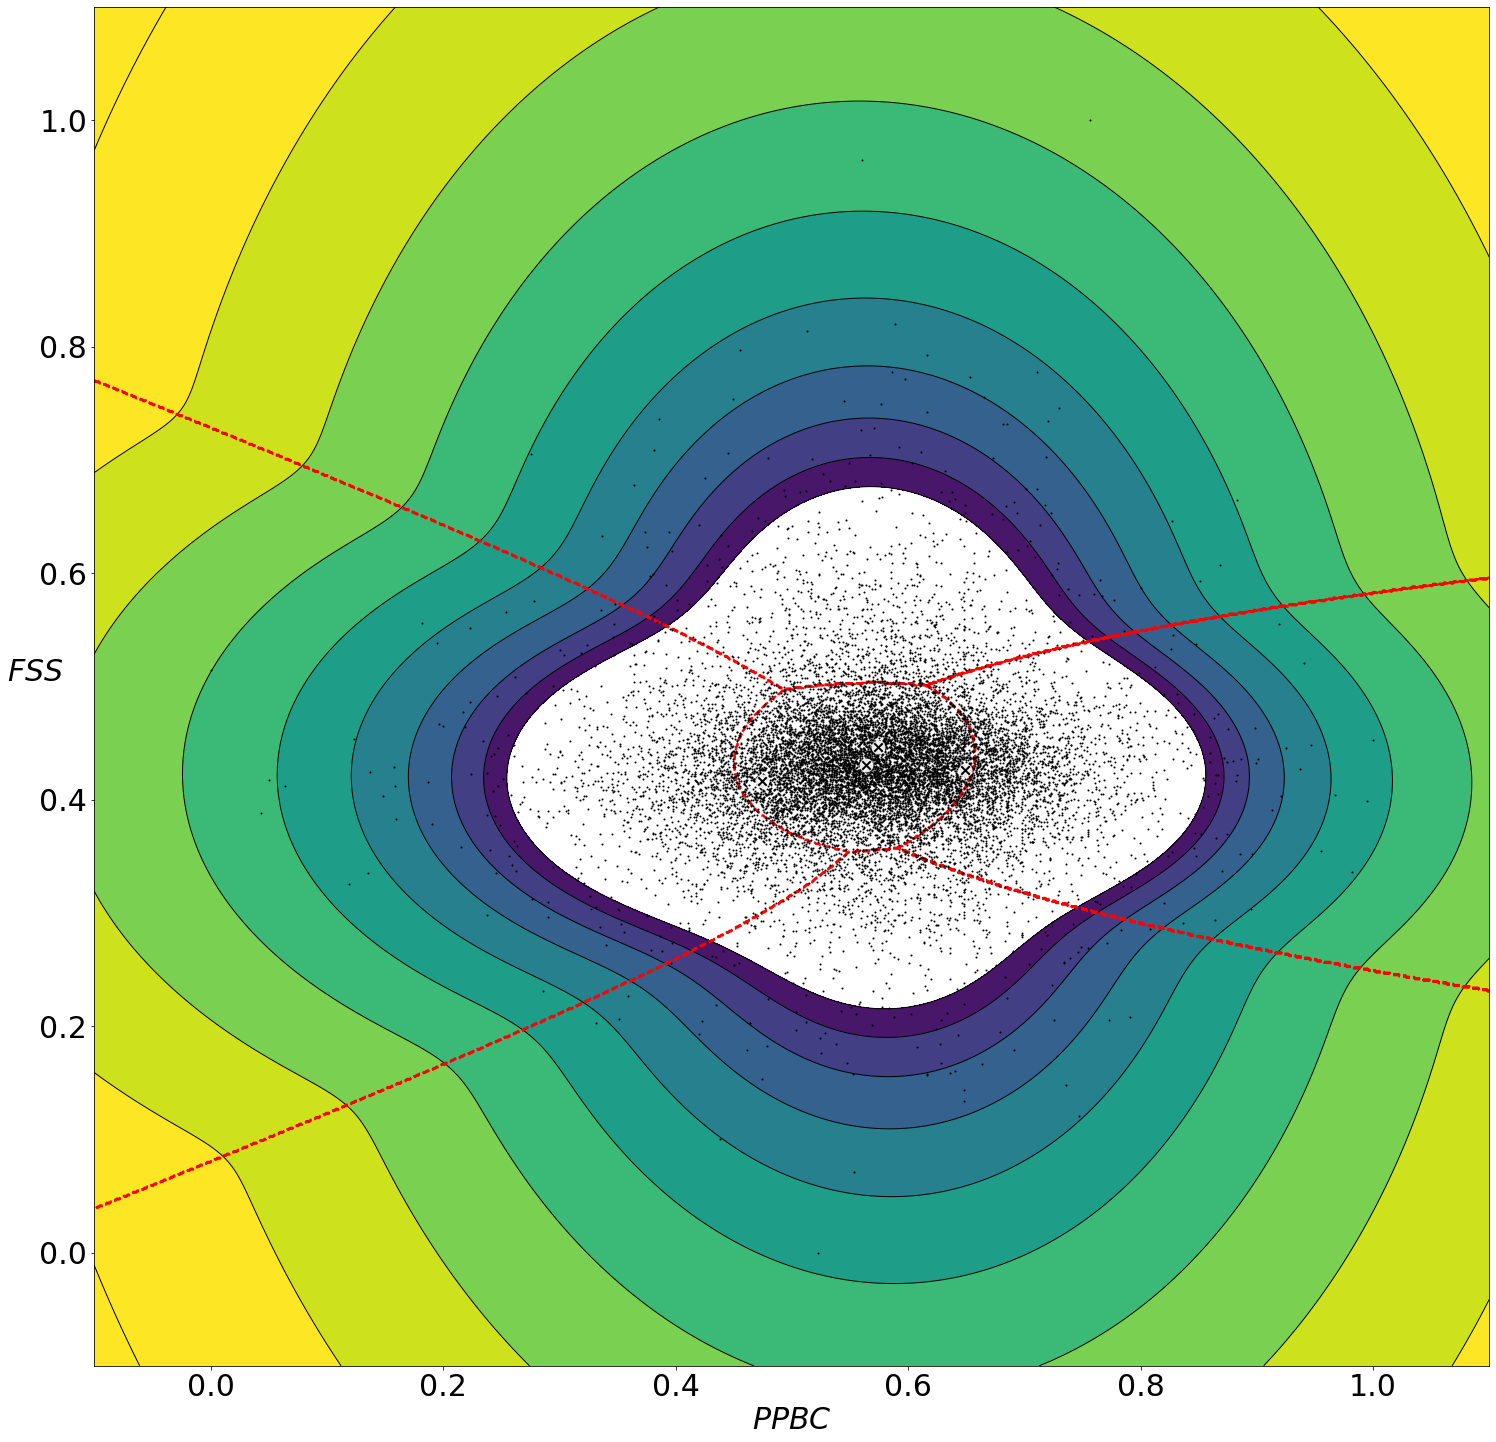

In [34]:
plt.figure(figsize=(25, 25))

plot_gaussian_mixture(gm, df_scaled_X)

plt.show() # Density map of this data

### 3.2 Looking at different covariance types

In [35]:
gm_full = GaussianMixture(n_components=4, n_init=10, covariance_type="full", random_state=42)
gm_tied = GaussianMixture(n_components=4, n_init=10, covariance_type="tied", random_state=42)
gm_spherical = GaussianMixture(n_components=4, n_init=10, covariance_type="spherical", random_state=42)
gm_diag = GaussianMixture(n_components=4, n_init=10, covariance_type="diag", random_state=42)
gm_full.fit(df_scaled_X) # Every cluster can take on any shape
gm_tied.fit(df_scaled_X) # All clusters must have the same ellipsoidal shape, size, and orientation (i.e., all clusters share the same covariance matrix).
gm_spherical.fit(df_scaled_X) # All clusters must be spherical, but they can have different diameters (i.e., different variances).
gm_diag.fit(df_scaled_X) # Clusters can take on any ellipsoidal shape of any size, but the ellipsoid’s axes must be parallel to the coordinate axes (i.e., the covariance matrices must be diagonal).

GaussianMixture(covariance_type='diag', n_components=4, n_init=10,
                random_state=42)

In [36]:
def compare_gaussian_mixtures(gm1, gm2, X):
    plt.figure(figsize=(25, 25))

    plt.subplot(121)
    plot_gaussian_mixture(gm1, X)
    plt.title('covariance_type="{}"'.format(gm1.covariance_type), fontsize=30)

    plt.subplot(122)
    plot_gaussian_mixture(gm2, X, show_ylabels=False)
    plt.title('covariance_type="{}"'.format(gm2.covariance_type), fontsize=30)

C:\Users\Maya\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
C:\Users\Maya\AppData\Local\Temp\ipykernel_17532\4202035290.py:11: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contourf(xx, yy, Z,
C:\Users\Maya\AppData\Local\Temp\ipykernel_17532\4202035290.py:14: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contour(xx, yy, Z,
C:\Users\Maya\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
C:\Users\Maya\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
C:\Users\Maya\AppData\Local\Temp\ipykernel_17532\4202035290.py:11: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contourf(xx, yy, Z,
C:\Users

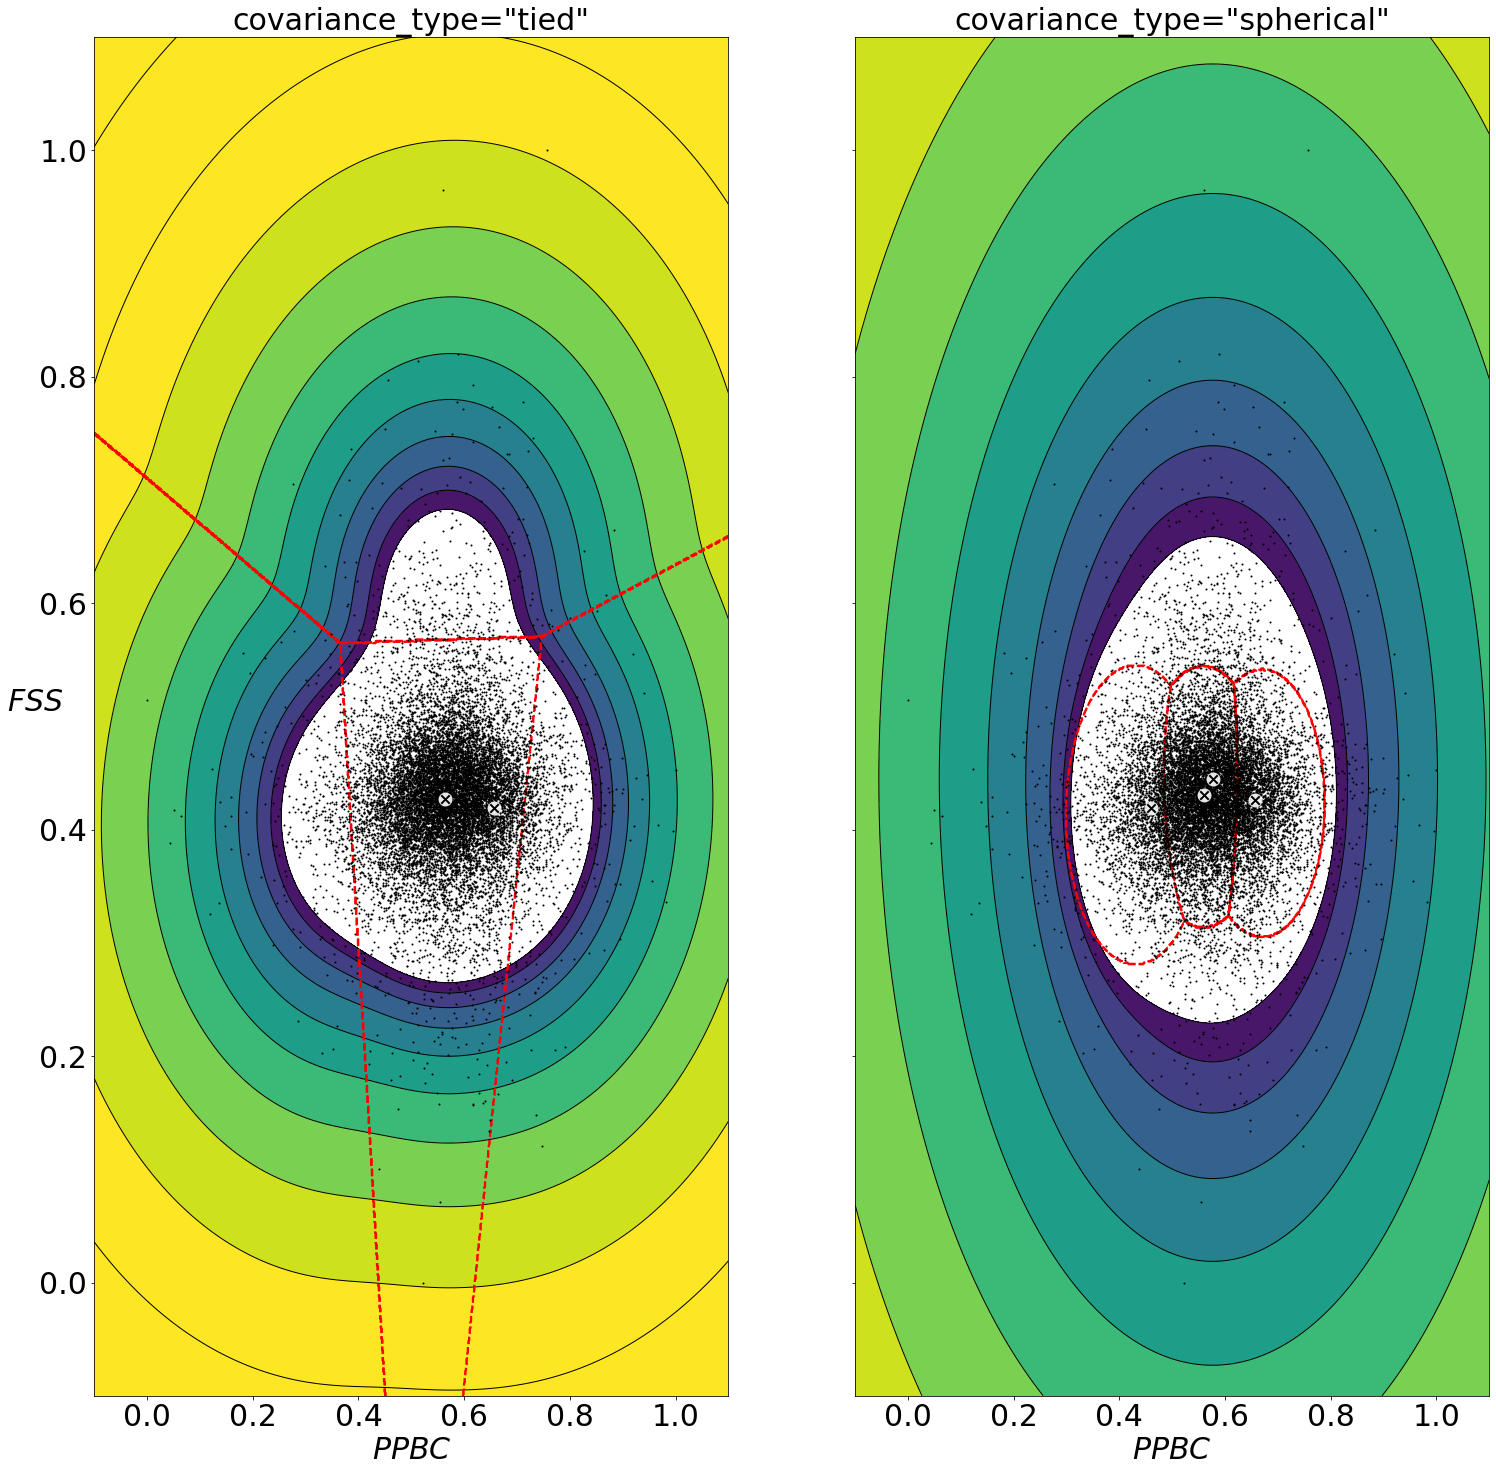

In [37]:
compare_gaussian_mixtures(gm_tied, gm_spherical, df_scaled_X)

plt.show()

C:\Users\Maya\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
C:\Users\Maya\AppData\Local\Temp\ipykernel_17532\4202035290.py:11: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contourf(xx, yy, Z,
C:\Users\Maya\AppData\Local\Temp\ipykernel_17532\4202035290.py:14: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contour(xx, yy, Z,
C:\Users\Maya\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
C:\Users\Maya\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
C:\Users\Maya\AppData\Local\Temp\ipykernel_17532\4202035290.py:11: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contourf(xx, yy, Z,
C:\Users

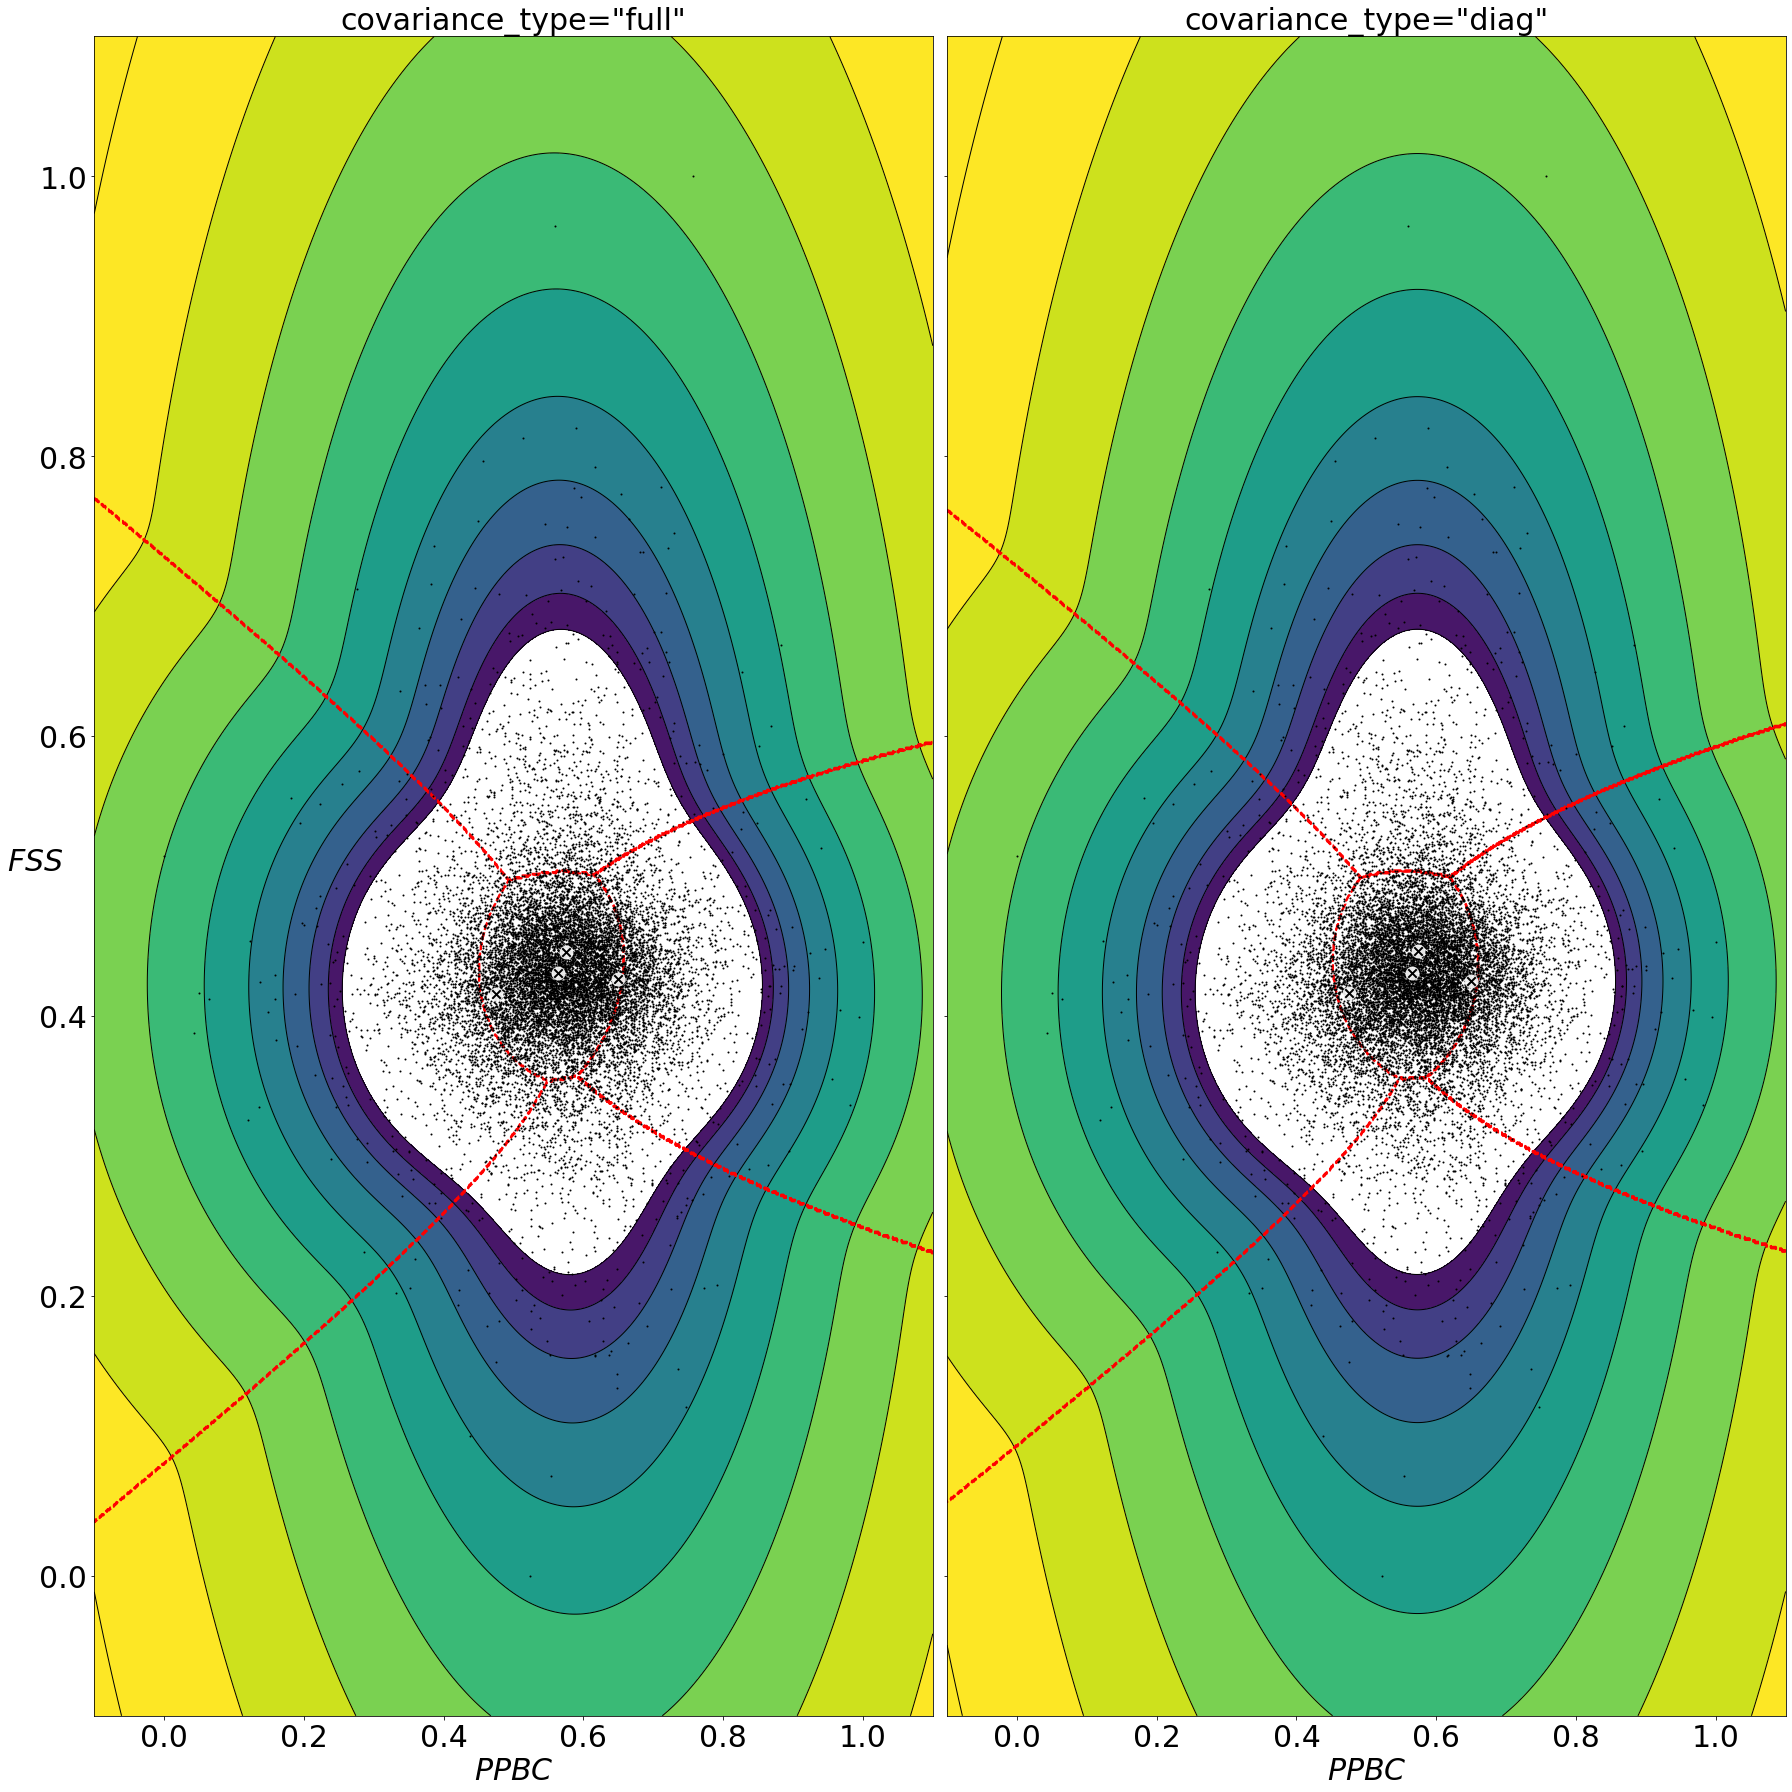

In [38]:
compare_gaussian_mixtures(gm_full, gm_diag, df_scaled_X)
plt.tight_layout()
plt.show()

### 3.3 Bayesian information criterion (BIC) and Akaike information criterion (AIC) to determine best cluster number and best covariance type

#### BIC and the AIC penalize models that have more parameters to learn (e.g., more clusters) and reward models that fit the data well.

In [39]:
gm.bic(df_scaled_X)

-68311.25357223129

In [40]:
gm.aic(df_scaled_X)


-68485.27927917732

In [41]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(df_scaled_X)
             for k in range(1, 11)]

In [42]:
bics = [model.bic(df_scaled_X) for model in gms_per_k]
aics = [model.aic(df_scaled_X) for model in gms_per_k]


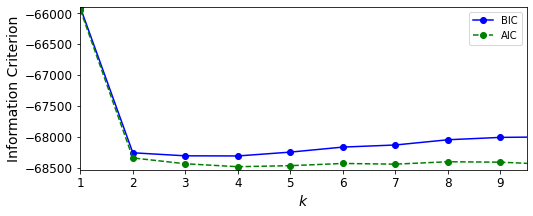

In [43]:
plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 9.5, np.min(aics) - 50, np.max(aics) + 50])
plt.legend()
plt.show()


In [44]:
min_bic = np.infty

for k in range(1, 11):
    for covariance_type in ("full", "tied", "spherical", "diag"):
        bic = GaussianMixture(n_components=k, n_init=10,
                              covariance_type=covariance_type,
                              random_state=42).fit(df_scaled_X).bic(df_scaled_X)
        if bic < min_bic:
            min_bic = bic
            best_k = k
            best_covariance_type = covariance_type

In [45]:
best_k

4

In [46]:
best_covariance_type

'diag'

##### This seems to confirm the silhouette score with a k=4 being best for this data. A diagonal covariance fit is best.

### 3.4 Anomaly detection

In [47]:
gm_diag = GaussianMixture(n_components=2, n_init=10, covariance_type="diag", random_state=42)
gm.diag = gm_diag.fit(df_scaled_X) # Using diagonal fit since the BIC/AIC said it was the best covariance type


In [48]:
densities = gm_diag.score_samples(df_scaled_X)
df_scaled_X['densities'] = densities
density_threshold = np.percentile(densities, 2) # Top 2% outliers
anomalies = df_scaled_X[densities < density_threshold]

print(f'The threshold of the score is {density_threshold:.2f}')
# Label the anomalies
df_scaled_X['anomaly_gmm_pct'] = df_scaled_X['densities'].apply(lambda x: 1 if x < density_threshold else 0)

The threshold of the score is -1.24


In [49]:

print(df_scaled_X.sort_values('densities').to_string())

                        DEG_PPBC   DEG_FSS  densities  anomaly_gmm_pct
gene_symbol                                                           
SPANXB1                 0.756561  1.000000 -19.281848                1
GLRA3                   0.560043  0.964546 -15.394263                1
DDIT4                   0.000000  0.514084 -11.245778                1
POTEJ                   0.522943  0.000000  -9.701256                1
VPS37D                  0.043207  0.387958  -9.105820                1
TCP11L2                 0.049979  0.416826  -8.718373                1
PFKFB4                  0.063848  0.412388  -8.168188                1
MUC15                   0.588765  0.820202  -7.364091                1
FAM83A                  0.513008  0.813374  -7.110595                1
ZNF467                  0.119456  0.325553  -6.755925                1
UGT8                    0.455778  0.796725  -6.711424                1
PPP1R14C                0.711193  0.777725  -6.340494                1
PI15  

C:\Users\Maya\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
C:\Users\Maya\AppData\Local\Temp\ipykernel_17532\4202035290.py:11: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contourf(xx, yy, Z,
C:\Users\Maya\AppData\Local\Temp\ipykernel_17532\4202035290.py:14: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contour(xx, yy, Z,
C:\Users\Maya\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(


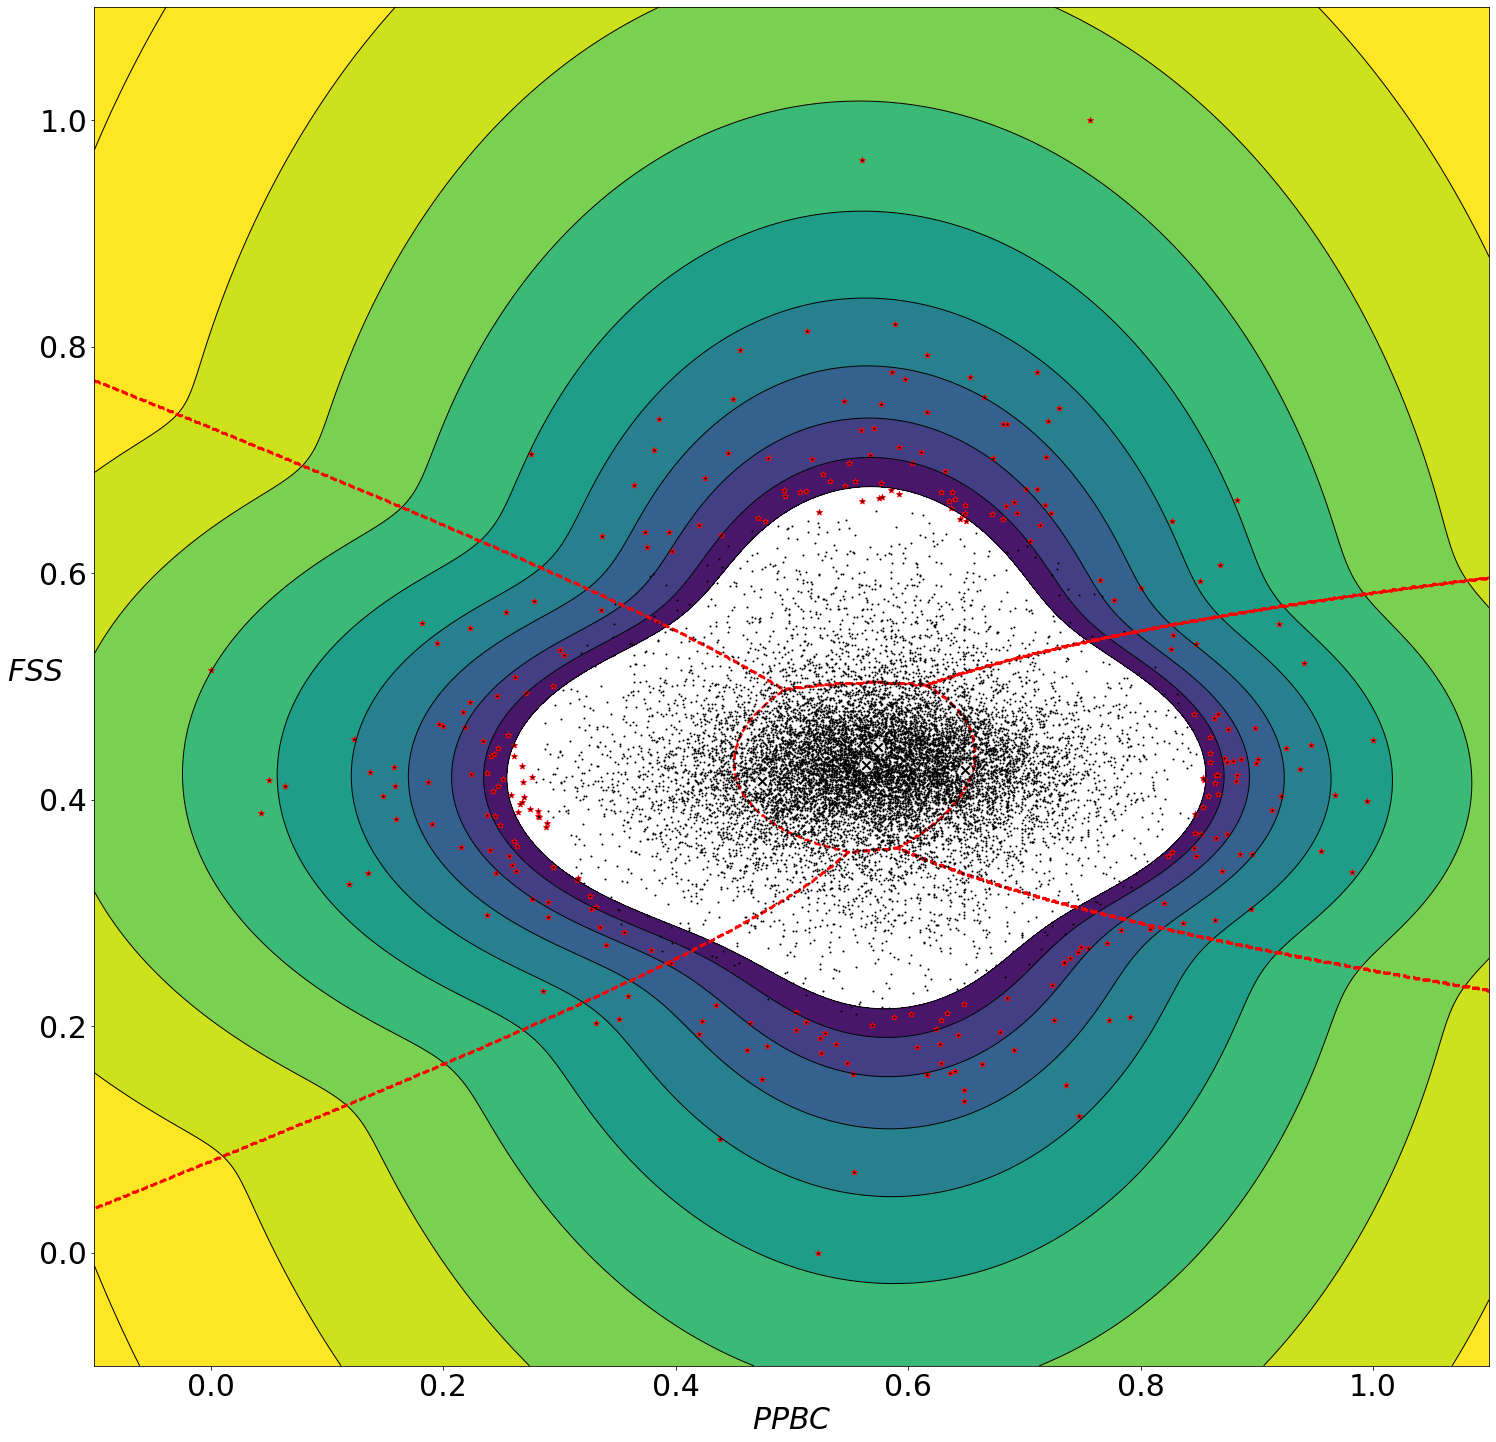

In [50]:
plt.figure(figsize=(25, 25))

plot_gaussian_mixture(gm, df_scaled_X)
plt.scatter(anomalies.iloc[:, 0], anomalies.iloc[:, 1], color='r', marker='*')
plt.ylim(top=1.1)
plt.show()